# [1] Install Dependencies (Run First!)

In [ ]:
!pip install sdv pandas faker scikit-learn matplotlib seaborn --quiet

In [ ]:
import sdv
print(sdv.__version__)

1.18.0


# [2] Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sdv.single_table import GaussianCopulaSynthesizer  # Correct import
from sdv.evaluation.single_table import evaluate_quality  # Corrected evaluation import
from faker import Faker
from pathlib import Path
import warnings
from google.colab import files

warnings.filterwarnings('ignore')

# [3] Load Data

In [ ]:
try:
    real_data = pd.read_csv('click_fraud_dataset.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Please upload your 'click_fraud_dataset.csv' file:")
    uploaded = files.upload()
    real_data = pd.read_csv(next(iter(uploaded.keys())))

print("\nFirst 5 rows of original data:")
print(real_data.head())

# Ensure correct data types
if 'timestamp' in real_data.columns:
    real_data['timestamp'] = pd.to_datetime(real_data['timestamp'])

Data loaded successfully!

First 5 rows of original data:
                               click_id            timestamp  \
0  d875835d-3a4a-4a20-b0d1-6cddf89afc6a  2024-08-23 02:47:39   
1  a2d3f028-7790-4be1-9f75-df1357edbbdb  2025-01-30 23:23:50   
2  36d787b2-fbce-43ef-8c02-7c8746d7e3db  2025-01-21 05:41:12   
3  01fc0078-096b-4f90-82ae-aa8085b719ac  2024-10-12 08:18:14   
4  0afdf2af-0b48-47d5-bfb6-e087053e1eb9  2024-04-19 14:44:35   

                                user_id      ip_address device_type browser  \
0  65a2f621-707b-49be-9c3e-ccac0b1d89ef    141.36.49.37      Tablet  Safari   
1  135e0114-76c5-43ea-bdef-80ab537dc009   216.29.19.201     Desktop   Opera   
2  a6922984-78cb-4c01-9c88-bfe3a13a0aaf  167.133.41.231      Tablet  Safari   
3  d30788b2-4048-4770-a4b1-a9358788818f   216.146.33.78      Tablet    Edge   
4  dfc42287-6325-4344-b373-b8e61ea6e5c1   146.37.54.245     Desktop   Opera   

  operating_system                        referrer_url  \
0          Android      

# [4] Data Exploration


Data Analysis Section

Dataset shape: (5000, 21)

Data types:
click_id                         object
timestamp                datetime64[ns]
user_id                          object
ip_address                       object
device_type                      object
browser                          object
operating_system                 object
referrer_url                     object
page_url                         object
click_duration                  float64
scroll_depth                      int64
mouse_movement                    int64
keystrokes_detected               int64
ad_position                      object
click_frequency                   int64
time_since_last_click             int64
device_ip_reputation             object
VPN_usage                         int64
proxy_usage                       int64
bot_likelihood_score            float64
is_fraudulent                     int64
dtype: object


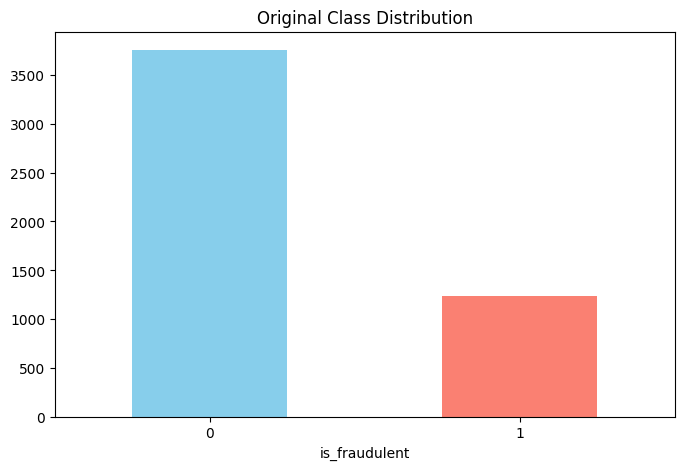

In [ ]:
print("\n" + "="*40)
print("Data Analysis Section")
print("="*40)

# Basic Info
print(f"\nDataset shape: {real_data.shape}")
print("\nData types:")
print(real_data.dtypes)

# Class Distribution
if 'is_fraudulent' in real_data.columns:
    plt.figure(figsize=(8,5))
    real_data['is_fraudulent'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Original Class Distribution')
    plt.xticks(rotation=0)
    plt.show()
else:
    print("Warning: 'is_fraudulent' column missing in dataset!")


# [5] Synthetic Data Generation

In [ ]:
print("\n" + "="*40)
print("Generating Synthetic Data")
print("="*40)

# ✅ Fixed Code (Corrected)
from sdv.metadata import SingleTableMetadata

# Automatically detect metadata from dataset
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(real_data)

# Define the synthesizer model with metadata
model = GaussianCopulaSynthesizer(metadata)

# Fit the model to real data
model.fit(real_data)

# Generate synthetic data (2x the original size)
synthetic_data = model.sample(num_rows=len(real_data)*2)

print("\nFirst 5 synthetic samples:")
print(synthetic_data.head())



Generating Synthetic Data

First 5 synthetic samples:
        click_id           timestamp        user_id  \
0  sdv-id-OLvbFT 2024-07-12 00:22:09  sdv-pii-wpf3c   
1  sdv-id-DZIyKt 2024-02-22 20:27:02  sdv-pii-boh6l   
2  sdv-id-hJpUWh 2024-11-28 09:26:43  sdv-pii-x6oy1   
3  sdv-id-lKBqmQ 2024-07-20 16:27:27  sdv-pii-3qsd4   
4  sdv-id-ZmNLJN 2024-03-03 06:57:02  sdv-pii-5egun   

                                ip_address device_type  browser  \
0  3417:8578:2659:7b96:f58b:4a76:9c8e:5400      Tablet     Edge   
1  93f1:6e24:c20f:101d:3c07:20f2:4d93:b2c9     Desktop   Chrome   
2  3fad:5005:cae6:a441:78d8:60ca:8d68:a411     Desktop  Firefox   
3  63da:fa7b:eac5:5ef8:571e:a161:cfa8:fbab     Desktop  Firefox   
4  1b78:c5bf:30bd:2e30:ae4a:e97b:5616:1936     Desktop     Edge   

  operating_system   referrer_url       page_url  click_duration  ...  \
0            Linux  sdv-pii-oqyy5  sdv-pii-hjpsv            4.37  ...   
1          Android  sdv-pii-8g9v5  sdv-pii-ogkzl            1.33 

# [6] Enhance Realism

In [ ]:
print("\n" + "="*40)
print("Enhancing Synthetic Data Realism")
print("="*40)

def enhance_synthetic_data(synthetic_df):
    if 'timestamp' in synthetic_df.columns:
        synthetic_df['timestamp'] = pd.to_datetime(synthetic_df['timestamp'], errors='coerce')
        synthetic_df['hour'] = synthetic_df['timestamp'].dt.hour.fillna(0).astype(int)

    if 'is_fraudulent' in synthetic_df.columns:
        # Simulate VPN usage for fraudulent clicks
        fraud_mask = synthetic_df['is_fraudulent'] == 1
        synthetic_df.loc[fraud_mask, 'VPN_usage'] = np.random.choice([0, 1], p=[0.2, 0.8], size=fraud_mask.sum())

        if 'mouse_movement' in synthetic_df.columns:
            synthetic_df.loc[fraud_mask, 'mouse_movement'] *= 0.3  # Reduce mouse movement for fraudsters

    return synthetic_df

enhanced_data = enhance_synthetic_data(synthetic_data)
print("\nEnhanced synthetic data samples:")
print(enhanced_data.head())


Enhancing Synthetic Data Realism

Enhanced synthetic data samples:
        click_id           timestamp        user_id  \
0  sdv-id-OLvbFT 2024-07-12 00:22:09  sdv-pii-wpf3c   
1  sdv-id-DZIyKt 2024-02-22 20:27:02  sdv-pii-boh6l   
2  sdv-id-hJpUWh 2024-11-28 09:26:43  sdv-pii-x6oy1   
3  sdv-id-lKBqmQ 2024-07-20 16:27:27  sdv-pii-3qsd4   
4  sdv-id-ZmNLJN 2024-03-03 06:57:02  sdv-pii-5egun   

                                ip_address device_type  browser  \
0  3417:8578:2659:7b96:f58b:4a76:9c8e:5400      Tablet     Edge   
1  93f1:6e24:c20f:101d:3c07:20f2:4d93:b2c9     Desktop   Chrome   
2  3fad:5005:cae6:a441:78d8:60ca:8d68:a411     Desktop  Firefox   
3  63da:fa7b:eac5:5ef8:571e:a161:cfa8:fbab     Desktop  Firefox   
4  1b78:c5bf:30bd:2e30:ae4a:e97b:5616:1936     Desktop     Edge   

  operating_system   referrer_url       page_url  click_duration  ...  \
0            Linux  sdv-pii-oqyy5  sdv-pii-hjpsv            4.37  ...   
1          Android  sdv-pii-8g9v5  sdv-pii-ogkzl    

# [7] Data Validation

In [ ]:
print("\n" + "="*40)
print("Data Validation")
print("="*40)

if 'click_duration' in real_data.columns and 'click_duration' in enhanced_data.columns:
    from sdv.evaluation.single_table import evaluate_quality

    from sdv.evaluation.single_table import evaluate_quality

    from sdv.metadata import SingleTableMetadata
    from sdv.evaluation.single_table import evaluate_quality

    # Create a fresh metadata object for enhanced data
    enhanced_metadata = SingleTableMetadata()
    enhanced_metadata.detect_from_dataframe(enhanced_data)

    from sdv.metadata import SingleTableMetadata
    from sdv.evaluation.single_table import evaluate_quality

    # Debugging: Print column names
    print("Real Data Columns:", real_data.columns)
    print("Enhanced Data Columns:", enhanced_data.columns)

    # Ensure column names match
    missing_in_real = set(enhanced_data.columns) - set(real_data.columns)
    if missing_in_real:
        print(f"Removing extra columns from enhanced data: {missing_in_real}")
        enhanced_data = enhanced_data.drop(columns=missing_in_real)

    # Create a new metadata object for enhanced data
    enhanced_metadata = SingleTableMetadata()
    enhanced_metadata.detect_from_dataframe(enhanced_data)

    # Run evaluation
    quality_report = evaluate_quality(real_data, enhanced_data, enhanced_metadata)

    print("\nData Quality Report:")
    print(quality_report)


else:
    print("Warning: 'click_duration' column missing in dataset, skipping quality evaluation.")


Data Validation
Real Data Columns: Index(['click_id', 'timestamp', 'user_id', 'ip_address', 'device_type',
       'browser', 'operating_system', 'referrer_url', 'page_url',
       'click_duration', 'scroll_depth', 'mouse_movement',
       'keystrokes_detected', 'ad_position', 'click_frequency',
       'time_since_last_click', 'device_ip_reputation', 'VPN_usage',
       'proxy_usage', 'bot_likelihood_score', 'is_fraudulent'],
      dtype='object')
Enhanced Data Columns: Index(['click_id', 'timestamp', 'user_id', 'ip_address', 'device_type',
       'browser', 'operating_system', 'referrer_url', 'page_url',
       'click_duration', 'scroll_depth', 'mouse_movement',
       'keystrokes_detected', 'ad_position', 'click_frequency',
       'time_since_last_click', 'device_ip_reputation', 'VPN_usage',
       'proxy_usage', 'bot_likelihood_score', 'is_fraudulent'],
      dtype='object')
Generating report ...


|          | 0/21 [00:00<?, ?it/s]|
(1/2) Evaluating Column Shapes: |          | 0/21

# [8] Final Dataset Creation

In [ ]:
print("\n" + "="*40)
print("Creating Final Dataset")
print("="*40)

# Merge real and synthetic data
augmented_data = pd.concat([real_data, enhanced_data], ignore_index=True)
augmented_data = augmented_data.sample(frac=1).reset_index(drop=True)
augmented_data.to_csv('augmented_fraud_dataset.csv', index=False)

print(f"Final dataset size: {len(augmented_data)} rows")

# Check class distribution
if 'is_fraudulent' in augmented_data.columns:
    print("Class distribution:")
    print(augmented_data['is_fraudulent'].value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
else:
    print("Warning: 'is_fraudulent' column missing in dataset!")


Creating Final Dataset
Final dataset size: 15000 rows
Class distribution:
is_fraudulent
0    75.72%
1    24.28%
Name: proportion, dtype: object


# [9] Download Results

In [ ]:
print("\n" + "="*40)
print("Download Results")
print("="*40)

try:
    files.download('augmented_fraud_dataset.csv')
except:
    print("Right-click the file in Colab's file explorer and select 'Download'")


Download Results


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>